In [1]:
import numpy as np
from scipy import interpolate
from matplotlib.tri import Triangulation
import matplotlib.pyplot as plt

In [2]:
data=np.loadtxt('./data_tomo/V_mean.txt',comments='#')
X = np.unique(data[:,0])
Y = np.unique(data[:,1])
Z = np.unique(data[:,2])
nx,ny,nz = np.meshgrid(X,Y,Z)
V= np.zeros_like(nz)

In [3]:
m,n,p = np.shape(nz)
for i in range(m):
    for j in range(n):
        for k in range(p):
            ind = np.where( (data[:,0] == nx[i][j][k]) & (data[:,1] == ny[i][j][k]) & (data[:,2] == nz[i][j][k]))
            #print(nx[i][j][k],ny[i][j][k],nz[i][j][k])
            try:
                V[i][j][k] = data[ind[0],3]
            except:
                print(ind)

In [13]:
nz[0][0]

300.0

In [4]:
import V2RhoT_gibbs_lib as lib

In [5]:
DMM_no_atten = np.loadtxt('./databases/DMM_HP',comments='#')
# correction using grain size = 10 mm and oscillatio period of 75 seconds.
# Attenuation model of Jackson and Faul 2010
# Function: lib.atten_correction (T (oC),P (Pascal),VP (km/s),Vs (km/s),oscilation period (s), grain size (mm))
DMM_atten_corrected = np.copy(DMM_no_atten)
for i in range(len(DMM_atten_corrected)):
    DMM_atten_corrected[i,3],DMM_atten_corrected[i,4] = lib.atten_correction(DMM_atten_corrected[i,0],DMM_atten_corrected[i,1]*100000,
                                                         DMM_atten_corrected[i,3],DMM_atten_corrected[i,4],75,10)

# correction for melts
# These are relations from lab experiments. More details in Afonso et al., 2016 III
# Function: lib.velocity_melt_correction_mantle (T (oC),P (GPa),VP (km/s),Vs (km/s),oscilation period (s), grain size (mm))
DMM_atten_melt_corrected = np.copy(DMM_atten_corrected)
melt = np.zeros_like(DMM_atten_melt_corrected[:,0])
for i in range(len(DMM_atten_melt_corrected)):
    DMM_atten_melt_corrected[i,3],DMM_atten_melt_corrected[i,4],melt[i] = lib.velocity_melt_correction_mantle(DMM_atten_melt_corrected[i,0]-273.15,
                                                                                             DMM_atten_melt_corrected[i,1]/10000,
                                                             DMM_atten_melt_corrected[i,3],DMM_atten_melt_corrected[i,4])

In [161]:
### lithostatic pressure from ak135
def lithostatic_pressure(depth,density):
    Pressure_lith = np.zeros_like(depth)
    for j in range(len(depth)-1): 
        DepthCalculated = False
        i = 0
        Pressure = 0.
        d = np.absolute(depth[j])*1000.
        while DepthCalculated is False:
            if i > len(depth):
                print('Maximum depth reached.')
                break
            z1   = depth[i]*1000.
            Rho1 = density[i]
            z2   = depth[i+1]*1000.
            Rho2 = density[i+1]
            if d < depth[i+1]*1000.:
                Rho2 = Rho1 + (d - z1)/(z2 - z1)*(Rho2 - Rho1)
                dz = d - z1
                DepthCalculated = True
            else:
                dz = z2 - z1
                Pressure = Pressure + dz*(Rho1 + (Rho2 - Rho1)/2)*9.8
                i += 1
        Pressure_lith[j]=Pressure*1e-5 # in bar
        print(Pressure_lith[j],depth[j],density[j])
    p_func = interpolate.interp1d(depth,Pressure_lith)
    return p_func

In [21]:
### lithostatic pressure 
def lithostatic_pressure(depth,density):
    Pressure_lith = np.zeros_like(depth)
    # Check is the first index is at zero depth or not
    # If it is not then pressures is set equal rho*g*h
    # else is it set to 0
    if depth[0] != 0:
        Pressure_lith[0] = density[0] * depth[0]* 9.8 * 1e3 * 1e-5
    else:
        #thickness = (depth[1]-depth[0]) #*1e3
        Pressure_lith[0] = 0
    # Now looping through depths
    for j in range(len(depth)-2):
        thickness = (depth[j+2] - depth [j+1]) *1e3
        Pressure_lith[j+1]=Pressure_lith[j] + thickness*density[j+1] *9.8*1e-5
        
    # fixing last index
    Pressure_lith[-1] = Pressure_lith[-2] + (depth[-1] - depth [-2])*1e3 * density[-2]*9.8*1e-5 
    #print(depth[:],density[:],Pressure_lith[:])

    p_func = interpolate.interp1d(depth,Pressure_lith)
    return p_func

In [41]:
thresh_hold=1
def vel_to_temp_P_loop(nx,ny,nz,Vs,Table):
    Temperature_out = np.zeros_like(nx)
    Density_out     = np.zeros_like(nx)#+3300
    diff_Vs         = np.zeros_like(nx)
    P_out           = np.zeros_like(nx)
    melt_out        = np.zeros_like(nx)
    #Vp_out          = []#np.zeros_like(tomo[:,1])
    #Vs_out          = []#np.zeros_like(tomo[:,1])
    m,n,p=np.shape(nx)
    # looping over all the geospatial nodes
    for i in range(1):
        for j in range(1):
            #P_func=lithostatic_pressure(nz[i][j][:],Density_out[i][j][:])
            P_func=lib.pressure_inter
            threshhold = 10
            p_counter  = 0
            while threshhold > 0:
                #print(f'{p_counter} Pressure counter {threshhold}.')
                p_counter = p_counter+1
                for k in range(p):
                    P  = P_func(nz[i][j][k])
                    Vs_in = Vs[i][j][k]
                    P_table,temp,dens,vp,vs=lib.lookup_vs_P_accurate(Vs_in,P.tolist(),Table)
                    Temperature_out[i][j][k]=temp
                    Density_out[i][j][k]=dens
                P_func_new=lithostatic_pressure(nz[i][j][:],Density_out[i][j][:])
                threshhold = np.sqrt(((P_func_new(nz[i][j][:]) - P_func(nz[i][j][:])) ** 2).mean())
                #threshhold = P_func_new(nz[i][j][-1]) - P_func(nz[i][j][-1])
                
                #thresh_hold = abs(P_func_new(nz[i][j][:]) - P_func(nz[i][j][-1]))
                print(f'{p_counter} Pressure updated {threshhold}.')
                #print(threshhold)
                P_func = P_func_new
                #Temperature_out[i][j][k]=temp
                #Temperature_out[i][j][k]=temp
    return Temperature_out,Density_out 


In [42]:
T_P_loop,D_P_loop=vel_to_temp_P_loop(nx,ny,nz,V,DMM_atten_melt_corrected)

1 Pressure updated 913.6671263240239.
2 Pressure updated 79.69359081098095.
3 Pressure updated 8.501500000010129.
4 Pressure updated 0.0.


In [43]:
def vel_to_temp(nx,ny,nz,Vs,Table):
    Temperature_out = np.zeros_like(nx)
    Density_out     = np.zeros_like(nx) #+3300
    diff_Vs         = np.zeros_like(nx)
    P_out           = np.zeros_like(nx)
    melt_out        = np.zeros_like(nx)
    #Vp_out          = []#np.zeros_like(tomo[:,1])
    #Vs_out          = []#np.zeros_like(tomo[:,1])
    m,n,p=np.shape(nx)
    # looping over all the geospatial nodes
    for i in range(1):
        for j in range(1):
            #P_func=lithostatic_pressure(nz[i][j][:],Density_out[i][j][:])
            P_func=lib.pressure_inter
            for k in range(p):
                    P  = P_func(nz[i][j][k])
                    print(P)
                    Vs_in = Vs[i][j][k]
                    print(Vs_in)
                    P_table,temp,dens,vp,vs=lib.lookup_vs_P_accurate(Vs_in,P.tolist(),Table)
                    #print(dens)
                    Temperature_out[i][j][k]=temp
                    Density_out[i][j][k]=dens
                    print(Density_out[i][j][k])
    return Temperature_out,Density_out 

In [44]:
T,D=vel_to_temp(nx,ny,nz,V,DMM_atten_melt_corrected)

65324.44800000001
4.4008613
3385.64
82301.478
4.5544051
3450.565
100055.6088
4.6854635
3525.44
118315.36080000002
4.7774704
3591.6400000000003
137120.1104
4.8259661
3642.66


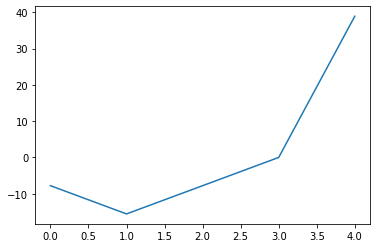

In [47]:
plt.plot(T[0][0][:]-T_P_loop[0][0][:])

In [46]:
D_P_loop[0][0][:]

array([3389.165, 3453.32 , 3526.99 , 3591.64 , 3647.18 ])

In [18]:
P=lithostatic_pressure(nz[0][0][:],D[0][0][:])
print(lib.pressure_inter(nz[0][0][:]),nz[0][0][:])
print(P(nz[0][0][:]),nz[0][0][:])

[ 65324.448   82301.478  100055.6088 118315.3608 137120.1104] [200. 250. 300. 350. 400.]
[ 66427.634  83348.902 100631.153 118230.189 135829.225] [200. 250. 300. 350. 400.]


In [19]:
p_new([200])

array([66427.634])

In [20]:
plt.plot(p_ini(D[0][0][:])-p_new(D[0][0][1:-1]))

ValueError: A value in x_new is above the interpolation range.

In [93]:
data=np.loadtxt('./data_tomo/NA_age_vel_stack.dat',comments='#')
X = np.unique(data[:,0])
#Y = np.unique(data[:,1])
Z = np.unique(data[:,1])
nx,nz = np.meshgrid(X,Z)
V= np.zeros_like(nz)

In [94]:
m,n = np.shape(nz)
for i in range(m):
    for k in range(p):
        ind = np.where( (data[:,0] == nx[i][k]) & (data[:,1] == nz[i][k]))
        #print(nx[i][j][k],ny[i][j][k],nz[i][j][k])
        #try:
        V[i][k] = data[ind[0],2]
        #except:
        #    print(ind)

In [27]:
tri = Triangulation(nx[1][:],-nz[1][:])
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(10,5))
m_v_in = ax.tricontourf(tri, V[1][:],cmap='RdBu',levels=np.arange(3.8,5,0.05))
ax.set_ylim([-400,0])
ax.set_xlabel('Age (Ma)')
ax.set_ylabel('Depth (km)')
fig.colorbar(m_v_in, ax=ax, label='CSEM Vs(km/s)', orientation='vertical')

RuntimeError: Error in qhull Delaunay triangulation calculation: singular input data (exitcode=2); use python verbose option (-v) to see original qhull error.

In [31]:
from mpl_toolkits.mplot3d import Axes3D


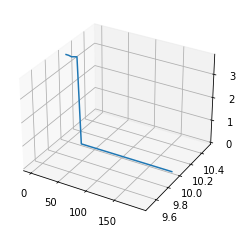

In [95]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(nx[1],nz[1],V[1])
plt.show()

In [58]:
thresh_hold=1
def vel_to_temp_2D(nx,nz,Vs,Table):
    Temperature_out = np.zeros_like(nx)
    Density_out     = np.zeros_like(nx) #+3300
    diff_Vs         = np.zeros_like(nx)
    P_out           = np.zeros_like(nx)
    melt_out        = np.zeros_like(nx)
    #Vp_out          = []#np.zeros_like(tomo[:,1])
    #Vs_out          = []#np.zeros_like(tomo[:,1])
    m,p=np.shape(nx)
    # looping over all the geospatial nodes
    for i in range(m):
        #P_func=lithostatic_pressure(nz[i][:],Density_out[i][:])
        P_func=lib.pressure_inter
        threshhold = 12000
        while threshhold >1000:
            for k in range(p):
                P  = P_func(nz[i][k])
                Vs_in = Vs[i][k]
                P_table,temp,dens,vp,vs=lib.lookup_vs_P_accurate(Vs_in,P.tolist(),Table)
                Temperature_out[i][k]=temp
                Density_out[i][k]=dens

            P_func_new=lithostatic_pressure(nz[i][:],Density_out[i][:])
            threshhold= np.sqrt(((P_func_new(nz[i][:]) - P_func(nz[i][:])) ** 2).mean())
            #thresh_hold = abs(P_func_new(nz[i][j][:]) - P_func(nz[i][j][-1]))
            print(threshhold)
            P_func = P_func_new
            #Temperature_out[i][j][k]=temp
            #Temperature_out[i][j][k]=temp
    return Temperature_out,Density_out 

In [59]:
T,D=vel_to_temp_2D(nx,nz,V,DMM_atten_melt_corrected)

c:\users\kumar\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\kumar\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


1274.0000000000002
0.0
2861.6000000000004
0.0
4292.4
0.0
7115.8293920000015
0.0
8848.592872000001
0.0
10581.356352000003
0.0
12314.119832
0.0
14046.883312000002
0.0
15755.143486486488
0.0
17426.648702702707
0.0
19098.15391891892
0.0
20769.659135135138
0.0
22441.16435135135
0.0
24112.669567567566
0.0
25784.17478378379
0.0
27455.680000000008
0.0
29061.116
0.0
30666.552
0.0
32271.98800000001
0.0
33877.42400000001
0.0
35482.860000000015
0.0
37088.296
0.0
38693.731999999996
0.0
40299.168000000005
0.0
41878.22566666667
0.0
43457.28333333333
0.0
45036.34100000002
0.0
46615.39866666667
0.0
48194.45633333336
0.0
49773.51400000002
0.0
51352.57166666668
0.0
52931.62933333334
0.0
54510.68700000002
0.0
56055.51000000002
0.0
57600.33300000001
0.0
59145.15600000002
0.0
60689.979000000014
0.0
62234.80200000001
0.0
63779.625000000015
0.0
65324.448000000004
0.0
66869.27100000001
0.0
68414.09400000003
0.0
70150.01699999999
0.0
71885.94
0.0
73621.863
0.0
75357.78600000002
0.0
77093.709
0.0
78829.632000000

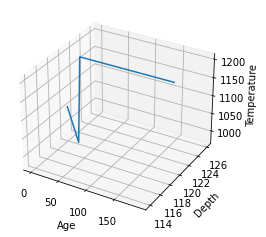

In [87]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
index=23
ax.plot(nx[:][index],nz[:][index],T[:][index])
ax.set_xlabel('Age')
ax.set_ylabel('Depth')
ax.set_zlabel('Temperature')
plt.show()

In [97]:
nx[:][10],nz[:][10],V[:][10],T[:][10]

(array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
        110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
        165., 170., 175., 180., 185., 190.]),
 array([55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55.,
        55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55.,
        55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55., 55.]),
 array([4.3982029 , 4.40572834, 4.41502047, 4.41996193, 4.42710114,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0. 

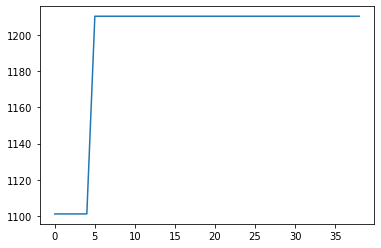

In [99]:
plt.plot(T[1][:])